In [1]:
!pip install brevitas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.6/626.6 kB 3.7 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

import brevitas.nn as qnn
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat


In [3]:
train_file = '/kaggle/input/fashionmnist/fashion-mnist_test.csv'
test_file = '/kaggle/input/fashionmnist/fashion-mnist_train.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018

NO_EPOCHS = 50
BATCH_SIZE = 128

print(train_data.shape)
print(test_data.shape)

(10000, 785)
(60000, 785)


In [4]:
def preprocess_data(dataset):
    labels_one_hot = pd.get_dummies(dataset.label).values
    print(labels_one_hot)

    num_images = dataset.shape[0]
    pixel_values = dataset.values[:, 1:]
    reshaped_images = pixel_values.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    normalized_images = reshaped_images / 255.0

    return normalized_images, labels_one_hot

X, y = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(f'X train is: {X_train.shape}')
print(f'Y train is: {y_train.shape}')
print(f'X validation is: {X_val.shape}')
print(f'Y validation is: {y_val.shape}')

[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ... False  True False]
 [False  True False ... False False False]]
[[False False  True ... False False False]
 [False False False ... False False  True]
 [False False False ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ... False  True False]
 [False False False ...  True False False]]
X train is: (8000, 28, 28, 1)
Y train is: (8000, 10)
X validation is: (2000, 28, 28, 1)
Y validation is: (2000, 10)


In [5]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = FashionMNISTDataset(X_train, y_train)
val_dataset = FashionMNISTDataset(X_val, y_val)
test_dataset = FashionMNISTDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class QuantizedCNN(nn.Module):
    def __init__(self):
        super(QuantizedCNN, self).__init__()
        self.quant_input = qnn.QuantIdentity(return_quant_tensor=True)
        
#out_channels = 32 (chosen as a common starting point for feature extraction)
        self.conv1 = qnn.QuantConv2d(
            in_channels=1, out_channels=32, kernel_size=3,
            bias=False, weight_quant=Int8WeightPerTensorFloat, return_quant_tensor=True)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
#out_channels = 64 (chosen to increase the network's capacity to learn features).
        self.conv2 = qnn.QuantConv2d(
            in_channels=32, out_channels=64, kernel_size=3,
            bias=False, weight_quant=Int8WeightPerTensorFloat, return_quant_tensor=True)
        self.dropout2 = nn.Dropout(0.25)
#in_channels = 64 (from conv2 output channels)
        self.conv3 = qnn.QuantConv2d(
            in_channels=64, out_channels=128, kernel_size=3,
            bias=False, weight_quant=Int8WeightPerTensorFloat, return_quant_tensor=True)
        self.dropout3 = nn.Dropout(0.4)
#Number of channels after conv3: 128
#Height and Width after conv3 and pool3: 1x1
#Calculation: 128×1×1=128
        self.fc1 = nn.Linear(128 * 1 * 1, 128)  # Adjusted based on feature map size
        self.dropout4 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, NUM_CLASSES)

    def forward(self, x):
        x = self.quant_input(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout3(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x


In [7]:
model = QuantizedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=NO_EPOCHS):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == torch.max(labels, 1)[1]).sum().item()
        print(f'Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total}%')

train_model(model, train_loader, val_loader, criterion, optimizer)


/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1900.)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/linear.py:114: UserWarning:

Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:368.)



Epoch 1, Loss: 1.6797461131262401
Validation Loss: 1.1058101877570152, Accuracy: 56.6%
Epoch 2, Loss: 1.029278402290647
Validation Loss: 0.7644047997891903, Accuracy: 72.1%
Epoch 3, Loss: 0.8278967482703072
Validation Loss: 0.7008677013218403, Accuracy: 73.2%
Epoch 4, Loss: 0.7479606384322757
Validation Loss: 0.6562439650297165, Accuracy: 73.8%
Epoch 5, Loss: 0.713167889723702
Validation Loss: 0.655422929674387, Accuracy: 74.35%
Epoch 6, Loss: 0.6890072945564513
Validation Loss: 0.6342431083321571, Accuracy: 75.0%
Epoch 7, Loss: 0.6602090313321068
Validation Loss: 0.6039786171168089, Accuracy: 76.4%
Epoch 8, Loss: 0.6475076292242322
Validation Loss: 0.585518604144454, Accuracy: 76.7%
Epoch 9, Loss: 0.6329640135878608
Validation Loss: 0.5748233031481504, Accuracy: 77.65%
Epoch 10, Loss: 0.6137846859674605
Validation Loss: 0.5723221153020859, Accuracy: 78.5%
Epoch 11, Loss: 0.6015309648854392
Validation Loss: 0.5631237719208002, Accuracy: 78.1%
Epoch 12, Loss: 0.5846324047398945
Validati

In [8]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()
    print(f'Test Accuracy: {100 * correct / total}%')

test_model(model, test_loader)


Test Accuracy: 86.02833333333334%


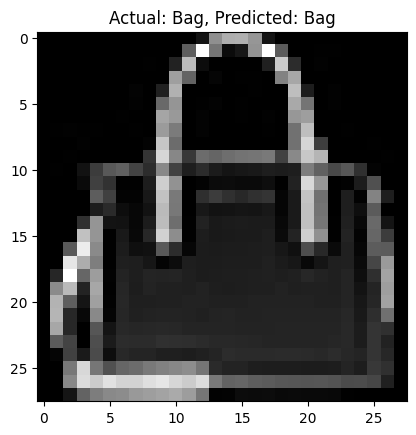

In [9]:
import matplotlib.pyplot as plt

class_labels = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

def show_prediction(model, test_dataset, index):
    model.eval()
    with torch.no_grad():
        image, label = test_dataset[index]
        image = image.unsqueeze(0)  # Add batch dimension

        output = model(image)
        _, predicted = torch.max(output, 1)

        predicted_label = class_labels[predicted.item()]
        actual_label = class_labels[torch.argmax(label).item()]

        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f'Actual: {actual_label}, Predicted: {predicted_label}')
        plt.show()

# Example usage
index=11
show_prediction(model, test_dataset, index)


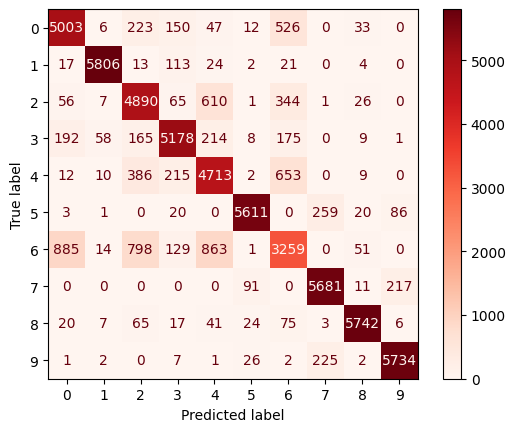

In [10]:
def predict_test_set(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = predict_test_set(model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(NUM_CLASSES))
disp.plot(cmap=plt.cm.Reds)
plt.show()
